## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
from sklearn.decomposition import PCA

**Попробуем классифицировать датасет, используя признаки, полученные с помощью:**
1. HOG дескрипторов, рассчитанных самостоятельно
2. HOG дексрипторов из библиотеки scikit-image
3. PCA преобразования, рассчитанного самостоятельно
4. PCA преобразования из библиотеки sklearn

**В качестве классификатора будем использовать RandomForestClassifier. Сравним результаты**

### Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [4]:
train_img.shape

(42000, 28, 28)

### Визуализируем исходные данные

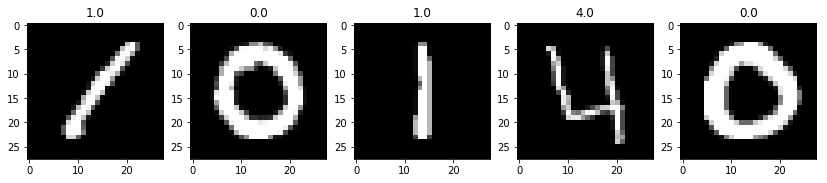

In [5]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

# 1. Классификация на основе HOG дескрипторов, полученных с помощью оператора Собеля

### Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [6]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [7]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

### Вычисляем угол и длину вектора градиента

In [8]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [9]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

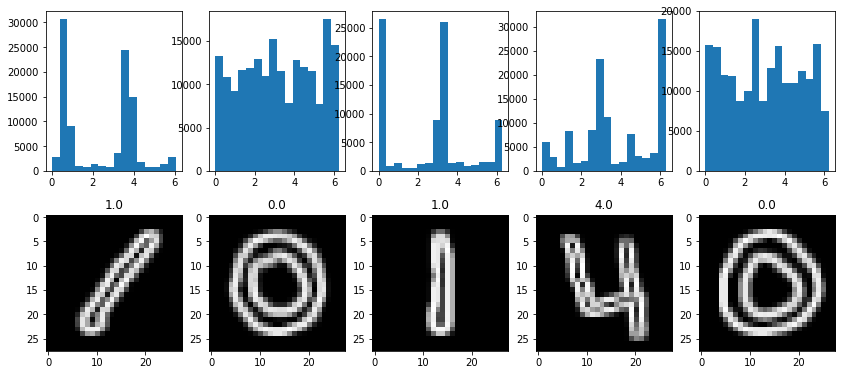

In [10]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

### Вычисляем гистограммы градиентов

In [11]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [12]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

### Нормируем вектор гистограммы

In [13]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [14]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

### Разбиваем выборку на обучение и валидацию

In [15]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

### Используем RandomForestClassifier для классификации


In [17]:
forest = RandomForestClassifier(n_estimators=100, 
                                max_depth=12, 
                                min_samples_leaf=3, 
                                random_state=17).fit(x_train, y_train)

In [18]:
pred_val_1 = forest.predict(x_val)

### Предсказание на тестовой выборке 

In [19]:
pred_test_1 = forest.predict(test_hist)

In [20]:
pred_test_1 = pred_test_1.astype(int)

### Оцениваем качество решение на валидационной выборке

In [21]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val_1))

Accuracy: 0.6309523809523809


In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val_1))

              precision    recall  f1-score   support

         0.0       0.42      0.35      0.39       816
         1.0       0.98      0.96      0.97       909
         2.0       0.50      0.42      0.46       846
         3.0       0.62      0.69      0.66       937
         4.0       0.70      0.68      0.69       839
         5.0       0.62      0.65      0.63       702
         6.0       0.45      0.44      0.45       785
         7.0       0.86      0.79      0.82       893
         8.0       0.48      0.58      0.53       835
         9.0       0.62      0.69      0.66       838

    accuracy                           0.63      8400
   macro avg       0.63      0.62      0.62      8400
weighted avg       0.63      0.63      0.63      8400



In [23]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val_1))

[[288   5  62  35  43  19 135  13 176  40]
 [  2 870   2   0  21   0   1   7   0   6]
 [ 52   0 358 145   1 104  57  17  95  17]
 [ 20   0  71 648   0  86  10   2  90  10]
 [ 12  13  10   4 570   1  90  30   6 103]
 [  6   0  71 123   1 453   6   5  36   1]
 [121   1  59   9  66   7 346  11  89  76]
 [  6   2  33   7  44  14  25 702   6  54]
 [122   0  35  54  13  38  39   7 487  40]
 [ 51   1  22  14  60   5  52  20  35 578]]


Не очень высокая точность, всего 0.63

# 2. Классификация на основе HOG дескрипторов, полученных с помощью библиотеки scikit-image

### Вычисляем HOG дескрипторы

In [24]:
def hog_descriptors(images):
    hogs = []
    for image in images:
        hog_desc = hog(image, orientations=16, pixels_per_cell=(8, 8), cells_per_block=(1, 1))
        hogs.append(hog_desc)
    
    return np.array(hogs)

In [25]:
train_hist = hog_descriptors(train_img)

In [26]:
test_hist = hog_descriptors(test_img)

### Разбиваем выборку на обучение и валидацию

In [27]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

### Используем RandomForestClassifier для классификации


In [28]:
forest = RandomForestClassifier(n_estimators=100, 
                                max_depth=12, 
                                min_samples_leaf=3, 
                                random_state=17).fit(x_train, y_train)

In [29]:
pred_val_2 = forest.predict(x_val)

### Предсказание на тестовой выборке 

In [30]:
pred_test_2 = forest.predict(test_hist)

In [31]:
pred_test_2 = pred_test_2.astype(int)

### Оцениваем качество решение на валидационной выборке

In [32]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val_2))

Accuracy: 0.9170238095238096


In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val_2))

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95       816
         1.0       0.98      0.97      0.98       909
         2.0       0.91      0.91      0.91       846
         3.0       0.85      0.90      0.87       937
         4.0       0.93      0.91      0.92       839
         5.0       0.91      0.93      0.92       702
         6.0       0.94      0.97      0.95       785
         7.0       0.92      0.88      0.90       893
         8.0       0.87      0.87      0.87       835
         9.0       0.90      0.89      0.89       838

    accuracy                           0.92      8400
   macro avg       0.92      0.92      0.92      8400
weighted avg       0.92      0.92      0.92      8400



In [34]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val_2))

[[778   6   2   6   3   7   7   2   2   3]
 [  0 886   4   0   9   0   1   6   2   1]
 [  4   0 768  44   6   5   1   4  12   2]
 [  3   0  12 842   0  10   2   4  55   9]
 [  2   2   8   5 762   1  26  13   4  16]
 [  2   1   0  22   3 652  10   4   7   1]
 [  6   3   0   0   3   7 764   0   2   0]
 [  0   2  30  13  14   4   0 782   7  41]
 [  7   3  12  37   6  24   4   4 727  11]
 [ 12   1   4  19   9   3   1  33  14 742]]


Используя HOG дескрипторы библиотеки scikit-image мы получаем точность намного большую, чем при использовании HOG дескрипторов, вычисленных "вручную". В данном случае точность составляет 0.917

# 3. Классификация на основе результата PCA преобразования

In [35]:
X_train = train_img.reshape(-1, 28 * 28).astype(np.float32)
X_test = test_img.reshape(-1, 28 * 28).astype(np.float32)

### Центрируем данные и находим матрицу ковариации признаков

In [36]:
X_train_mean = X_train.mean(axis=0)
X_train_centred = X_train - X_train_mean

X_test_mean = X_test.mean(axis=0)
X_test_centred = X_test - X_test_mean

In [37]:
train_cov = np.dot(X_train_centred.T, X_train_centred) / X_train_centred.shape[0]
test_cov = np.dot(X_test_centred.T, X_test_centred) / X_test_centred.shape[0]

### Находим собственные значения и их сумму

In [38]:
U_train, S_train, _ = np.linalg.svd(train_cov)
U_test, S_test, _ = np.linalg.svd(test_cov)

In [39]:
S_cumsum_train = np.cumsum(S_train) / np.sum(S_train)
S_cumsum_test = np.cumsum(S_test) / np.sum(S_test)

### Понижаем размерность

In [40]:
S_thr = 0.75  # задаем порог для накопленной суммы собственных значений

# определяем необходимое число компонент для заданного порога
n_comp_train = np.argmax(np.where(S_cumsum_train > S_thr, 1, 0))
n_comp_test = np.argmax(np.where(S_cumsum_test > S_thr, 1, 0))

In [41]:
Xrot_reduced_train = np.dot(X_train_centred, U_train[:, :n_comp_train])
Xrot_reduced_test = np.dot(X_test_centred, U_test[:, :n_comp_test])

### Разбиваем выборку на обучение и валидацию

In [42]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, Xrot_reduced_train, test_size=0.2,
    random_state=42)

### Используем RandomForestClassifier для классификации


In [43]:
forest = RandomForestClassifier(n_estimators=100, 
                                max_depth=12, 
                                min_samples_leaf=3, 
                                random_state=17).fit(x_train, y_train)

In [44]:
pred_val_3 = forest.predict(x_val)

### Предсказание на тестовой выборке 

In [45]:
pred_test_3 = forest.predict(Xrot_reduced_test)

In [46]:
pred_test_3 = pred_test_3.astype(int)

### Оцениваем качество решение на валидационной выборке

In [47]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val_3))

Accuracy: 0.9257142857142857


In [48]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val_3))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       816
         1.0       0.97      0.98      0.98       909
         2.0       0.93      0.92      0.92       846
         3.0       0.90      0.88      0.89       937
         4.0       0.93      0.91      0.92       839
         5.0       0.89      0.92      0.91       702
         6.0       0.94      0.97      0.95       785
         7.0       0.94      0.92      0.93       893
         8.0       0.88      0.89      0.89       835
         9.0       0.89      0.90      0.90       838

    accuracy                           0.93      8400
   macro avg       0.93      0.93      0.93      8400
weighted avg       0.93      0.93      0.93      8400



In [49]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val_3))

[[789   0   1   4   3   1   9   2   7   0]
 [  0 891   4   2   1   3   3   1   4   0]
 [  5   5 775  13  12   3   3   7  21   2]
 [  4   1  13 826   2  27   5  12  35  12]
 [  3   0   4   1 766   4  10   5   8  38]
 [  2   0   4  15   7 649  10   2  10   3]
 [  8   1   4   0   3   8 758   0   3   0]
 [  1  10  18   1   8   4   0 822   4  25]
 [  1   5   7  33   6  20   7   3 743  10]
 [  2   4   6  18  16   9   0  19   7 757]]


При использовании PCA преобразования точность еще немного выше - 0.926

# 4. Классификация на основе PCA из sklearn

In [50]:
X_train = train_img.reshape(-1, 28 * 28).astype(np.float32)
X_test = test_img.reshape(-1, 28 * 28).astype(np.float32)

In [69]:
pca = PCA()

In [70]:
pca.fit(X_train, train_label)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [71]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, X_train_pca, test_size=0.2,
    random_state=42)

In [72]:
forest = RandomForestClassifier(n_estimators=100, 
                                max_depth=12, 
                                min_samples_leaf=3, 
                                random_state=17).fit(x_train, y_train)

In [73]:
pred_val_4 = forest.predict(x_val)

In [74]:
pred_test_4 = forest.predict(X_test_pca)

In [75]:
pred_test_4 = pred_test_4.astype(int)

In [76]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, pred_val_4))

Accuracy: 0.8908333333333334


In [77]:
from sklearn.metrics import classification_report
print(classification_report(y_val, pred_val_4))

              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       816
         1.0       0.94      0.99      0.96       909
         2.0       0.89      0.90      0.90       846
         3.0       0.85      0.87      0.86       937
         4.0       0.89      0.90      0.89       839
         5.0       0.89      0.80      0.84       702
         6.0       0.90      0.95      0.93       785
         7.0       0.89      0.90      0.89       893
         8.0       0.86      0.80      0.83       835
         9.0       0.86      0.85      0.85       838

    accuracy                           0.89      8400
   macro avg       0.89      0.89      0.89      8400
weighted avg       0.89      0.89      0.89      8400



In [78]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val_4))

[[776   0   2   5   3   5  17   1   6   1]
 [  0 896   4   1   1   1   4   1   1   0]
 [ 11   7 760  12  11   4   8   8  25   0]
 [  4   3  23 815   2  19   8  14  34  15]
 [  1   5   7   0 752   0  17   7   5  45]
 [ 10   0  10  45  14 563  22   4  24  10]
 [ 12   2   8   1   6   6 748   0   2   0]
 [  0  19  16   3  14   3   0 800   7  31]
 [ 16  11  16  56  15  27   6   8 664  16]
 [  5   7   6  17  27   7   0  56   4 709]]


Без настройки PCA из библиотеки sklearn дает результат хуже, чем самостоятельно рассчитанное PCA преобразование. В данном случае точность равна 0.891

**Итого** самая высокая точность была достигнута при самостоятельно рассчитанном PCA преобразовании и при HOG дескрипторах из scikit-image (эти результаты и будем использовать для Kaggle соревнования). Самая низкая точноть была при самостоятельно рассчитанных HOG дескрипторах.

## Готовим файл для отправки

In [84]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test_2, 1):
        dst.write('%s,%s\n' % (i, p))

In [85]:
!head submit.txt

ImageId,Label
1,2
2,0
3,2
4,3
5,3
6,7
7,0
8,3
9,0


In [86]:
# Your submission scored 0.92185